Code are based on:<br>
https://www.kaggle.com/code/chaos2629/transformer-model-training <br>
and <br>
https://www.kaggle.com/code/charanreddysunkara/gislr-tf-data-processing-transformer-training

In [1]:
!pip install tensorflow-addons

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 9.3 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sn

from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split, GroupShuffleSplit

import glob
import sys
import os
import math
import gc
import sys
import sklearn
import scipy


/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
googledrive_dir = '/content/drive/MyDrive/Colab Notebooks/Data/asl-signs/'

In [5]:
X_train = np.load(f'{googledrive_dir}/X.npy')
y_train = np.load(f'{googledrive_dir}/y.npy')
NON_EMPTY_FRAME_IDXS_TRAIN = np.load(f'{googledrive_dir}/NON_EMPTY_FRAME_IDXS.npy')

In [14]:
NON_EMPTY_FRAME_IDXS_TRAIN = np.load(f'{googledrive_dir}/NON_EMPTY_FRAME_IDXS.npy')

In [11]:
X_train.shape

(94477, 64, 66, 3)

In [12]:
y_train.shape

(94477,)

In [8]:
X_train.dtype

dtype('float32')

In [9]:
y_train.dtype

dtype('int32')

In [15]:
NON_EMPTY_FRAME_IDXS_TRAIN.shape

(94477, 64)

In [16]:
display(pd.Series(y_train).value_counts().to_frame('Class Count').iloc[[0,1,2,3,4, -5,-4,-3,-2,-1]])

,Class Count
135,415
136,414
194,411
60,410
148,408
56,312
170,312
21,310
231,307
249,299


In [17]:
# Epsilon value for layer normalisation
LAYER_NORM_EPS = 1e-6

# Dense layer units for landmarks
LIPS_UNITS = 384
HANDS_UNITS = 384
POSE_UNITS = 384
# final embedding and transformer embedding size
UNITS = 512

# Transformer
NUM_BLOCKS = 2
MLP_RATIO = 2

# Dropout
EMBEDDING_DROPOUT = 0.00
MLP_DROPOUT_RATIO = 0.30
CLASSIFIER_DROPOUT_RATIO = 0.10

# Initiailizers
INIT_HE_UNIFORM = tf.keras.initializers.he_uniform
INIT_GLOROT_UNIFORM = tf.keras.initializers.glorot_uniform
INIT_ZEROS = tf.keras.initializers.constant(0.0)
# Activations
GELU = tf.keras.activations.gelu

print(f'UNITS: {UNITS}')

UNITS: 512


In [18]:
# If True, processing data from scratch
# If False, loads preprocessed data
PREPROCESS_DATA = False
TRAIN_MODEL = True
# True: use 10% of participants as validation set
# False: use all data for training -> gives better LB result
USE_VAL = False

N_ROWS = 543
N_DIMS = 3
DIM_NAMES = ['x', 'y', 'z']
SEED = 42
NUM_CLASSES = 250
IS_INTERACTIVE = True
VERBOSE = 1 if IS_INTERACTIVE else 2

INPUT_SIZE = 64

BATCH_ALL_SIGNS_N = 4
BATCH_SIZE = 256
N_EPOCHS = 100
LR_MAX = 1e-3
N_WARMUP_EPOCHS = 0
WD_RATIO = 0.05
MASK_VAL = 4237

In [19]:
USE_TYPES = ['left_hand', 'pose', 'right_hand']
START_IDX = 468
LIPS_IDXS0 = np.array([
        61, 185, 40, 39, 37, 0, 267, 269, 270, 409,
        291, 146, 91, 181, 84, 17, 314, 405, 321, 375,
        78, 191, 80, 81, 82, 13, 312, 311, 310, 415,
        95, 88, 178, 87, 14, 317, 402, 318, 324, 308,
    ])
# Landmark indices in original data
LEFT_HAND_IDXS0 = np.arange(468,489)
RIGHT_HAND_IDXS0 = np.arange(522,543)
LEFT_POSE_IDXS0 = np.array([502, 504, 506, 508, 510])
RIGHT_POSE_IDXS0 = np.array([503, 505, 507, 509, 511])
LANDMARK_IDXS_LEFT_DOMINANT0 = np.concatenate((LIPS_IDXS0, LEFT_HAND_IDXS0, LEFT_POSE_IDXS0))
LANDMARK_IDXS_RIGHT_DOMINANT0 = np.concatenate((LIPS_IDXS0, RIGHT_HAND_IDXS0, RIGHT_POSE_IDXS0))
HAND_IDXS0 = np.concatenate((LEFT_HAND_IDXS0, RIGHT_HAND_IDXS0), axis=0)
N_COLS = LANDMARK_IDXS_LEFT_DOMINANT0.size
# Landmark indices in processed data
LIPS_IDXS = np.argwhere(np.isin(LANDMARK_IDXS_LEFT_DOMINANT0, LIPS_IDXS0)).squeeze()
LEFT_HAND_IDXS = np.argwhere(np.isin(LANDMARK_IDXS_LEFT_DOMINANT0, LEFT_HAND_IDXS0)).squeeze()
RIGHT_HAND_IDXS = np.argwhere(np.isin(LANDMARK_IDXS_LEFT_DOMINANT0, RIGHT_HAND_IDXS0)).squeeze()
HAND_IDXS = np.argwhere(np.isin(LANDMARK_IDXS_LEFT_DOMINANT0, HAND_IDXS0)).squeeze()
POSE_IDXS = np.argwhere(np.isin(LANDMARK_IDXS_LEFT_DOMINANT0, LEFT_POSE_IDXS0)).squeeze()

print(f'# HAND_IDXS: {len(HAND_IDXS)}, N_COLS: {N_COLS}')

# HAND_IDXS: 21, N_COLS: 66


In [20]:
LIPS_START = 0
LEFT_HAND_START = LIPS_IDXS.size
RIGHT_HAND_START = LEFT_HAND_START + LEFT_HAND_IDXS.size
POSE_START = RIGHT_HAND_START + RIGHT_HAND_IDXS.size

print(f'LIPS_START: {LIPS_START}, LEFT_HAND_START: {LEFT_HAND_START}, RIGHT_HAND_START: {RIGHT_HAND_START}, POSE_START: {POSE_START}')

LIPS_START: 0, LEFT_HAND_START: 40, RIGHT_HAND_START: 61, POSE_START: 61


  0%|          | 0/40 [00:00<?, ?it/s]

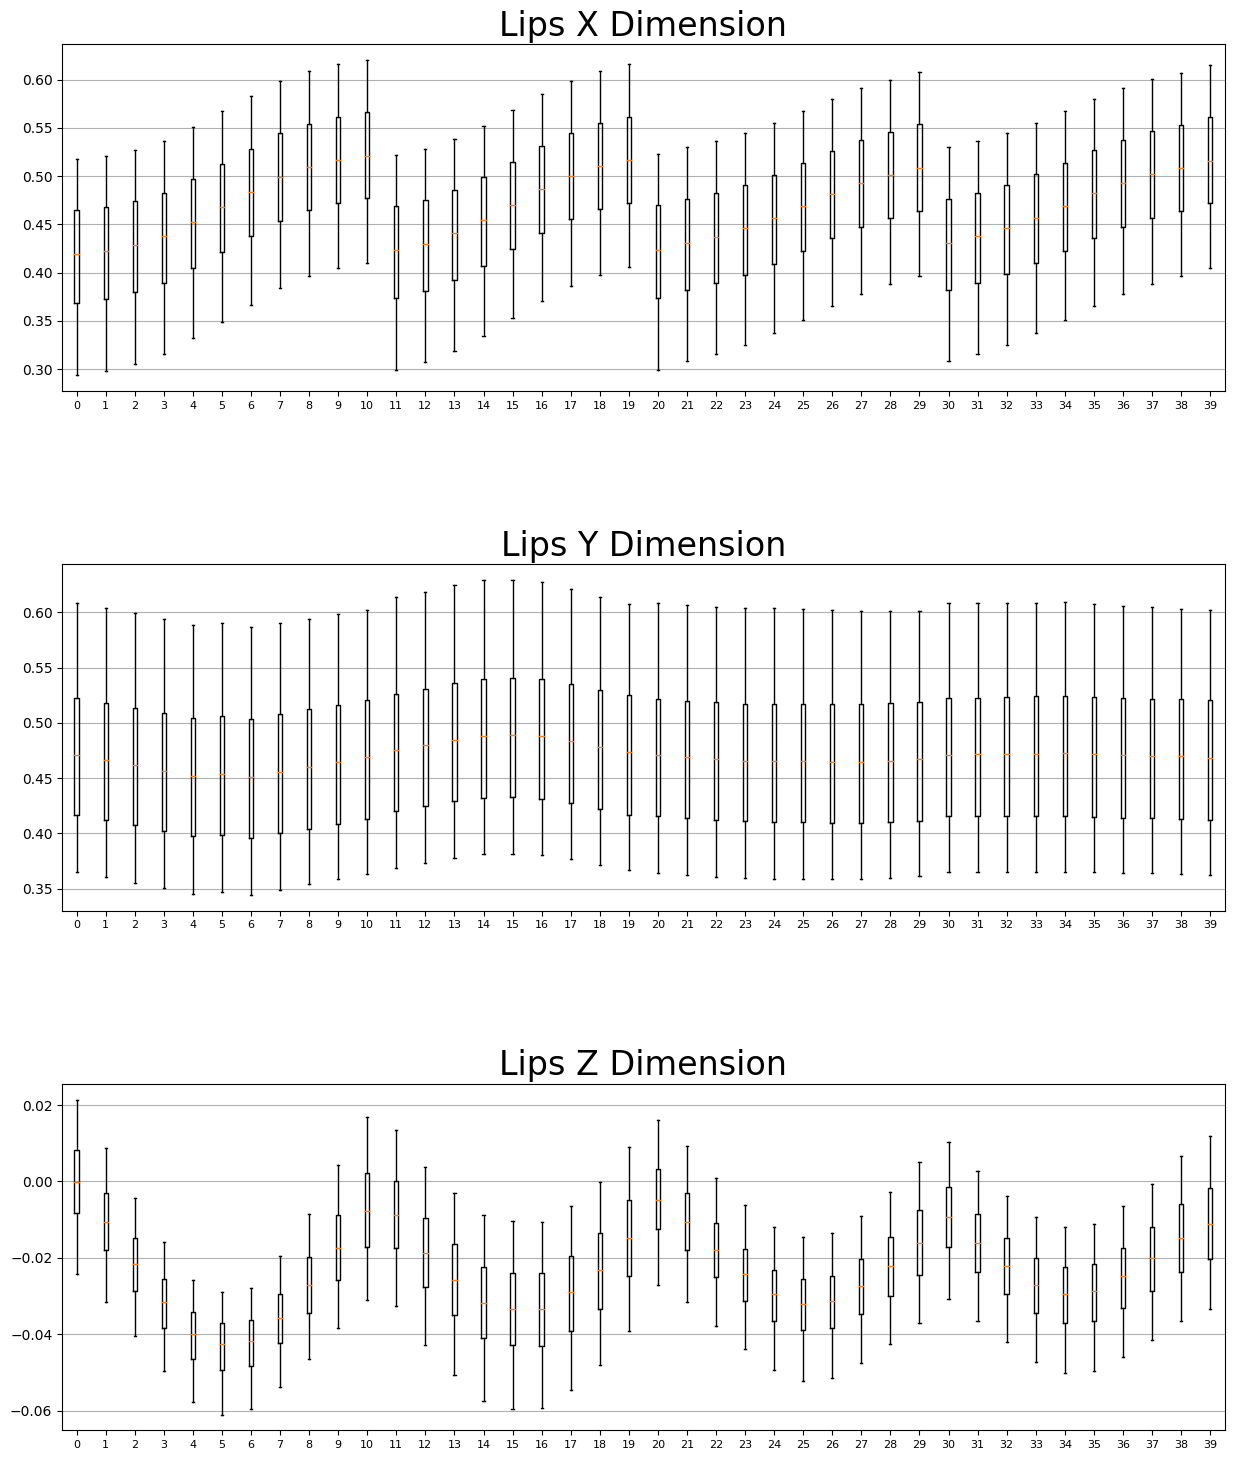

In [21]:
def get_lips_mean_std():
    # LIPS
    LIPS_MEAN_X = np.zeros([LIPS_IDXS.size], dtype=np.float32)
    LIPS_MEAN_Y = np.zeros([LIPS_IDXS.size], dtype=np.float32)
    LIPS_STD_X = np.zeros([LIPS_IDXS.size], dtype=np.float32)
    LIPS_STD_Y = np.zeros([LIPS_IDXS.size], dtype=np.float32)

    fig, axes = plt.subplots(3, 1, figsize=(15, N_DIMS*6))

    for col, ll in enumerate(tqdm( np.transpose(X_train[:,:,LIPS_IDXS], [2,3,0,1]).reshape([LIPS_IDXS.size, N_DIMS, -1]) )):
        for dim, l in enumerate(ll):
            v = l[np.nonzero(l)]
            if dim == 0: # X
                LIPS_MEAN_X[col] = v.mean()
                LIPS_STD_X[col] = v.std()
            if dim == 1: # Y
                LIPS_MEAN_Y[col] = v.mean()
                LIPS_STD_Y[col] = v.std()

            axes[dim].boxplot(v, notch=False, showfliers=False, positions=[col], whis=[5,95])

    for ax, dim_name in zip(axes, DIM_NAMES):
        ax.set_title(f'Lips {dim_name.upper()} Dimension', size=24)
        ax.tick_params(axis='x', labelsize=8)
        ax.grid(axis='y')

    plt.subplots_adjust(hspace=0.50)
    plt.show()

    LIPS_MEAN = np.array([LIPS_MEAN_X, LIPS_MEAN_Y]).T
    LIPS_STD = np.array([LIPS_STD_X, LIPS_STD_Y]).T

    return LIPS_MEAN, LIPS_STD

LIPS_MEAN, LIPS_STD = get_lips_mean_std()

  0%|          | 0/21 [00:00<?, ?it/s]

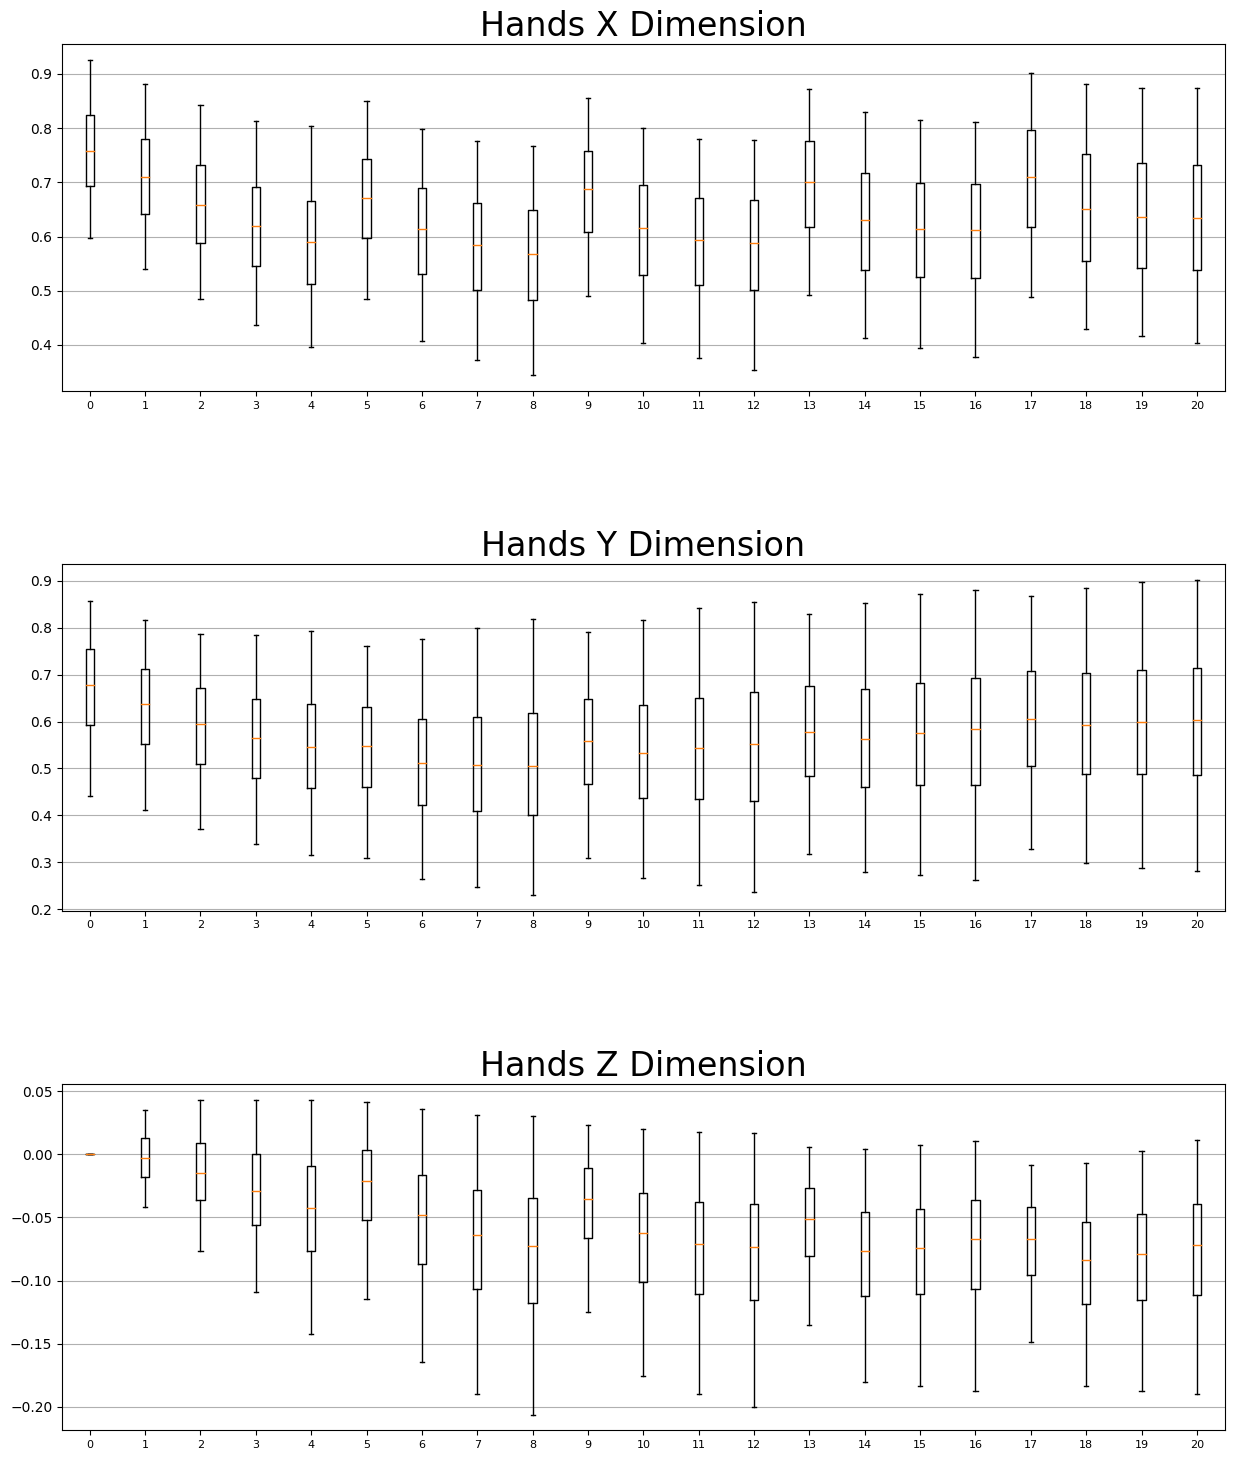

In [22]:
def get_left_right_hand_mean_std():
    # LEFT HAND
    LEFT_HANDS_MEAN_X = np.zeros([LEFT_HAND_IDXS.size], dtype=np.float32)
    LEFT_HANDS_MEAN_Y = np.zeros([LEFT_HAND_IDXS.size], dtype=np.float32)
    LEFT_HANDS_STD_X = np.zeros([LEFT_HAND_IDXS.size], dtype=np.float32)
    LEFT_HANDS_STD_Y = np.zeros([LEFT_HAND_IDXS.size], dtype=np.float32)

    fig, axes = plt.subplots(3, 1, figsize=(15, N_DIMS*6))

    for col, ll in enumerate(tqdm( np.transpose(X_train[:,:,LEFT_HAND_IDXS], [2,3,0,1]).reshape([LEFT_HAND_IDXS.size, N_DIMS, -1]) )):
        for dim, l in enumerate(ll):
            v = l[np.nonzero(l)]
            if dim == 0: # X
                LEFT_HANDS_MEAN_X[col] = v.mean()
                LEFT_HANDS_STD_X[col] = v.std()
            if dim == 1: # Y
                LEFT_HANDS_MEAN_Y[col] = v.mean()
                LEFT_HANDS_STD_Y[col] = v.std()
            # Plot
            axes[dim].boxplot(v, notch=False, showfliers=False, positions=[col], whis=[5,95])

    for ax, dim_name in zip(axes, DIM_NAMES):
        ax.set_title(f'Hands {dim_name.upper()} Dimension', size=24)
        ax.tick_params(axis='x', labelsize=8)
        ax.grid(axis='y')

    plt.subplots_adjust(hspace=0.50)
    plt.show()

    LEFT_HANDS_MEAN = np.array([LEFT_HANDS_MEAN_X, LEFT_HANDS_MEAN_Y]).T
    LEFT_HANDS_STD = np.array([LEFT_HANDS_STD_X, LEFT_HANDS_STD_Y]).T

    return LEFT_HANDS_MEAN, LEFT_HANDS_STD

LEFT_HANDS_MEAN, LEFT_HANDS_STD = get_left_right_hand_mean_std()

  0%|          | 0/5 [00:00<?, ?it/s]

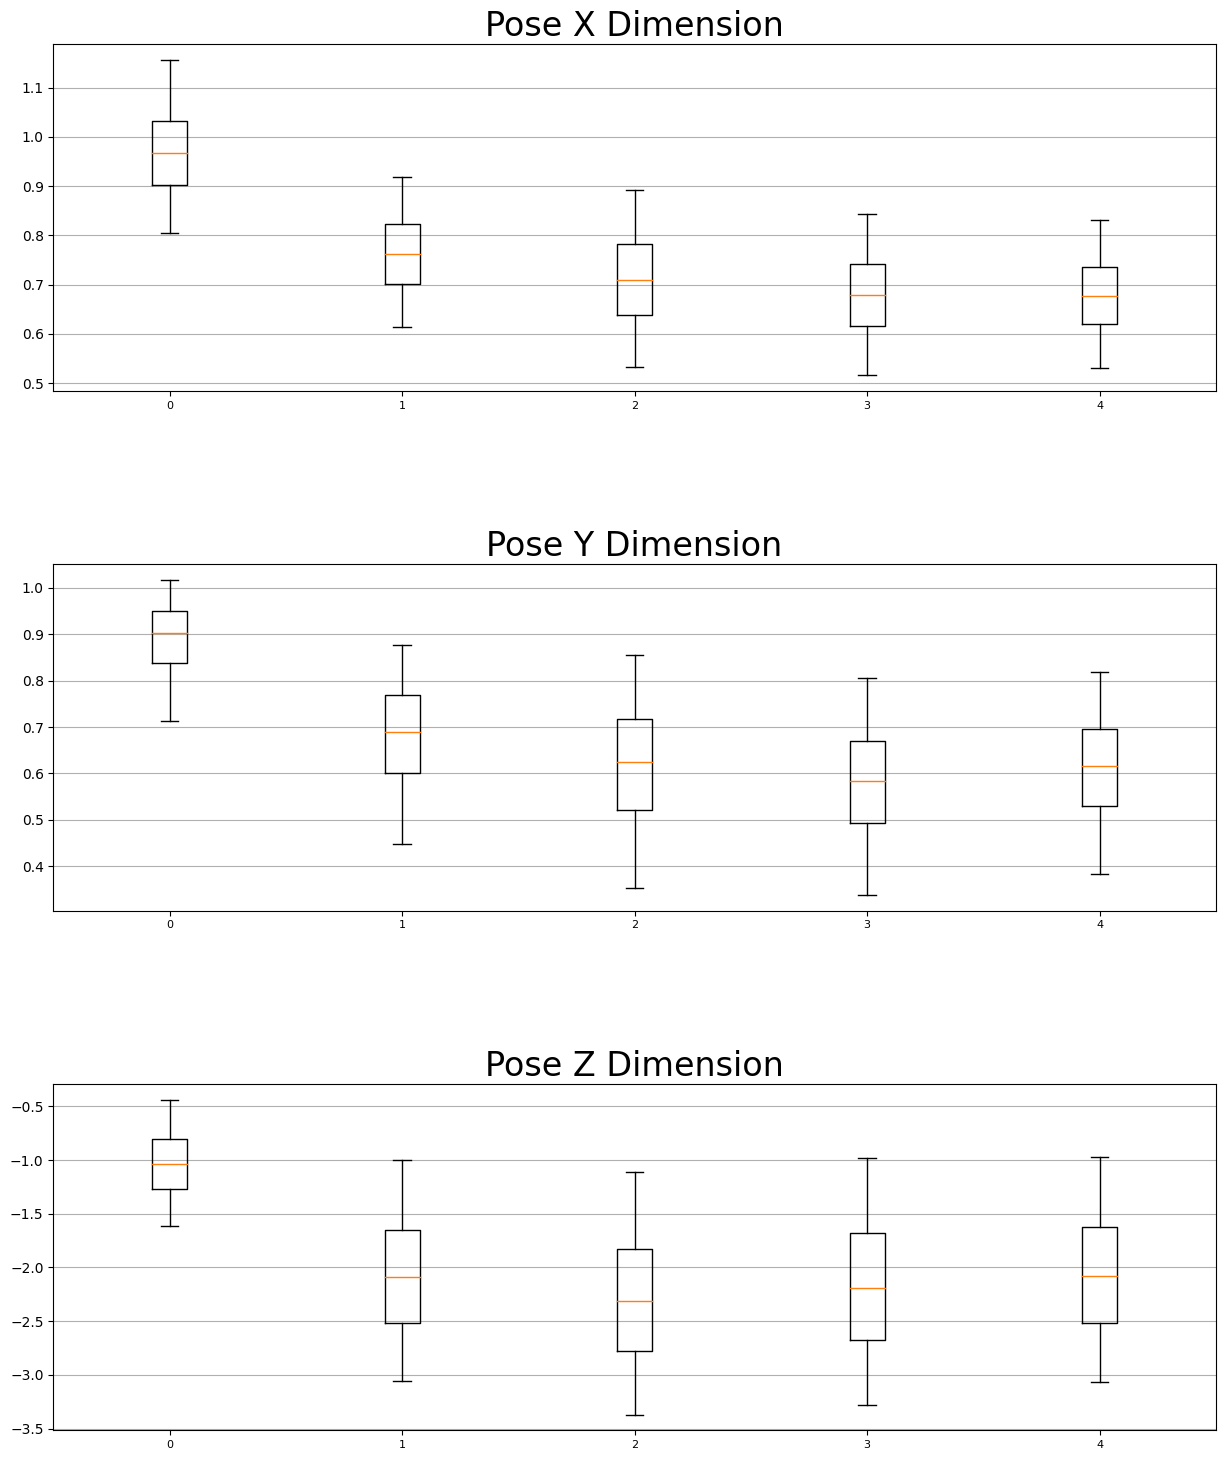

In [23]:
def get_pose_mean_std():
    # POSE
    POSE_MEAN_X = np.zeros([POSE_IDXS.size], dtype=np.float32)
    POSE_MEAN_Y = np.zeros([POSE_IDXS.size], dtype=np.float32)
    POSE_STD_X = np.zeros([POSE_IDXS.size], dtype=np.float32)
    POSE_STD_Y = np.zeros([POSE_IDXS.size], dtype=np.float32)

    fig, axes = plt.subplots(3, 1, figsize=(15, N_DIMS*6))

    for col, ll in enumerate(tqdm( np.transpose(X_train[:,:,POSE_IDXS], [2,3,0,1]).reshape([POSE_IDXS.size, N_DIMS, -1]) )):
        for dim, l in enumerate(ll):
            v = l[np.nonzero(l)]
            if dim == 0: # X
                POSE_MEAN_X[col] = v.mean()
                POSE_STD_X[col] = v.std()
            if dim == 1: # Y
                POSE_MEAN_Y[col] = v.mean()
                POSE_STD_Y[col] = v.std()

            axes[dim].boxplot(v, notch=False, showfliers=False, positions=[col], whis=[5,95])

    for ax, dim_name in zip(axes, DIM_NAMES):
        ax.set_title(f'Pose {dim_name.upper()} Dimension', size=24)
        ax.tick_params(axis='x', labelsize=8)
        ax.grid(axis='y')

    plt.subplots_adjust(hspace=0.50)
    plt.show()

    POSE_MEAN = np.array([POSE_MEAN_X, POSE_MEAN_Y]).T
    POSE_STD = np.array([POSE_STD_X, POSE_STD_Y]).T

    return POSE_MEAN, POSE_STD

POSE_MEAN, POSE_STD = get_pose_mean_std()

In [24]:
# based on: https://stackoverflow.com/questions/67342988/verifying-the-implementation-of-multihead-attention-in-transformer
# replaced softmax with softmax layer to support masked softmax
def scaled_dot_product(q,k,v, softmax, attention_mask):
    #calculates Q . K(transpose)
    qkt = tf.matmul(q,k,transpose_b=True)
    #caculates scaling factor
    dk = tf.math.sqrt(tf.cast(q.shape[-1],dtype=tf.float32))
    scaled_qkt = qkt/dk
    softmax = softmax(scaled_qkt, mask=attention_mask)

    z = tf.matmul(softmax,v)
    #shape: (m,Tx,depth), same shape as q,k,v
    return z

class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self,d_model,num_of_heads):
        super(MultiHeadAttention,self).__init__()
        self.d_model = d_model
        self.num_of_heads = num_of_heads
        self.depth = d_model//num_of_heads
        self.wq = [tf.keras.layers.Dense(self.depth) for i in range(num_of_heads)]
        self.wk = [tf.keras.layers.Dense(self.depth) for i in range(num_of_heads)]
        self.wv = [tf.keras.layers.Dense(self.depth) for i in range(num_of_heads)]
        self.wo = tf.keras.layers.Dense(d_model)
        self.softmax = tf.keras.layers.Softmax()

    def call(self,x, attention_mask):

        multi_attn = []
        for i in range(self.num_of_heads):
            Q = self.wq[i](x)
            K = self.wk[i](x)
            V = self.wv[i](x)
            multi_attn.append(scaled_dot_product(Q,K,V, self.softmax, attention_mask))

        multi_head = tf.concat(multi_attn,axis=-1)
        multi_head_attention = self.wo(multi_head)
        return multi_head_attention

In [25]:
# Full Transformer
class Transformer(tf.keras.Model):
    def __init__(self, num_blocks):
        super(Transformer, self).__init__(name='transformer')
        self.num_blocks = num_blocks

    def build(self, input_shape):
        self.ln_1s = []
        self.mhas = []
        self.ln_2s = []
        self.mlps = []
        # Make Transformer Blocks
        for i in range(self.num_blocks):
            # Multi Head Attention
            self.mhas.append(MultiHeadAttention(UNITS, 8))
            # Multi Layer Perception
            self.mlps.append(tf.keras.Sequential([
                tf.keras.layers.Dense(UNITS * MLP_RATIO, activation=GELU, kernel_initializer=INIT_GLOROT_UNIFORM),
                tf.keras.layers.Dropout(MLP_DROPOUT_RATIO),
                tf.keras.layers.Dense(UNITS, kernel_initializer=INIT_HE_UNIFORM),
            ]))

    def call(self, x, attention_mask):
        # Iterate input over transformer blocks
        for mha, mlp in zip(self.mhas, self.mlps):
            x = x + mha(x, attention_mask)
            x = x + mlp(x)

        return x

In [26]:
class LandmarkEmbedding(tf.keras.Model):
    def __init__(self, units, name):
        super(LandmarkEmbedding, self).__init__(name=f'{name}_embedding')
        self.units = units

    def build(self, input_shape):
        # Embedding for missing landmark in frame, initizlied with zeros
        self.empty_embedding = self.add_weight(
            name=f'{self.name}_empty_embedding',
            shape=[self.units],
            initializer=INIT_ZEROS,
        )
        # Embedding
        self.dense = tf.keras.Sequential([
            tf.keras.layers.Dense(self.units, name=f'{self.name}_dense_1', use_bias=False, kernel_initializer=INIT_GLOROT_UNIFORM),
            tf.keras.layers.Activation(GELU),
            tf.keras.layers.Dense(self.units, name=f'{self.name}_dense_2', use_bias=False, kernel_initializer=INIT_HE_UNIFORM),
        ], name=f'{self.name}_dense')

    def call(self, x):
        return tf.where(
                # Checks whether landmark is missing in frame
                tf.reduce_sum(x, axis=2, keepdims=True) == 0,
                # If so, the empty embedding is used
                self.empty_embedding,
                # Otherwise the landmark data is embedded
                self.dense(x),
            )

In [27]:
class Embedding(tf.keras.Model):
    def __init__(self):
        super(Embedding, self).__init__()

    def get_diffs(self, l):
        S = l.shape[2]
        other = tf.expand_dims(l, 3)
        other = tf.repeat(other, S, axis=3)
        other = tf.transpose(other, [0,1,3,2])
        diffs = tf.expand_dims(l, 3) - other
        diffs = tf.reshape(diffs, [-1, INPUT_SIZE, S*S])
        return diffs

    def build(self, input_shape):
        # Positional Embedding, initialized with zeros
        self.positional_embedding = tf.keras.layers.Embedding(INPUT_SIZE+1, UNITS, embeddings_initializer=INIT_ZEROS)
        # Embedding layer for Landmarks
        self.lips_embedding = LandmarkEmbedding(LIPS_UNITS, 'lips')
        self.left_hand_embedding = LandmarkEmbedding(HANDS_UNITS, 'left_hand')
        self.pose_embedding = LandmarkEmbedding(POSE_UNITS, 'pose')
        # Landmark Weights
        self.landmark_weights = tf.Variable(tf.zeros([3], dtype=tf.float32), name='landmark_weights')
        # Fully Connected Layers for combined landmarks
        self.fc = tf.keras.Sequential([
            tf.keras.layers.Dense(UNITS, name='fully_connected_1', use_bias=False, kernel_initializer=INIT_GLOROT_UNIFORM),
            tf.keras.layers.Activation(GELU),
            tf.keras.layers.Dense(UNITS, name='fully_connected_2', use_bias=False, kernel_initializer=INIT_HE_UNIFORM),
        ], name='fc')


    def call(self, lips0, left_hand0, pose0, non_empty_frame_idxs, training=False):
        # Lips
        lips_embedding = self.lips_embedding(lips0)
        # Left Hand
        left_hand_embedding = self.left_hand_embedding(left_hand0)
        # Pose
        pose_embedding = self.pose_embedding(pose0)
        # Merge Embeddings of all landmarks with mean pooling
        x = tf.stack((
            lips_embedding, left_hand_embedding, pose_embedding,
        ), axis=3)
        x = x * tf.nn.softmax(self.landmark_weights)
        x = tf.reduce_sum(x, axis=3)
        # Fully Connected Layers
        x = self.fc(x)
        # Add Positional Embedding
        max_frame_idxs = tf.clip_by_value(
                tf.reduce_max(non_empty_frame_idxs, axis=1, keepdims=True),
                1,
                np.PINF,
            )
        normalised_non_empty_frame_idxs = tf.where(
            tf.math.equal(non_empty_frame_idxs, -1.0),
            INPUT_SIZE,
            tf.cast(
                non_empty_frame_idxs / max_frame_idxs * INPUT_SIZE,
                tf.int32,
            ),
        )
        x = x + self.positional_embedding(normalised_non_empty_frame_idxs)

        return x

In [28]:
# Not used, adds random X/y translation to input on samples level
class Augmentation(tf.keras.layers.Layer):
    def __init__(self, noise_std):
        super(Augmentation, self).__init__()
        self.noise_std = noise_std

    def add_noise(self, t):
        B = tf.shape(t)[0]
        return tf.where(
            t == 0.0,
            0.0,
            t + tf.random.normal([B,1,1,tf.shape(t)[3]], 0, self.noise_std),
        )

    def call(self, lips0, left_hand0, pose0, training=False):
        if training:
            # Lips
            lips0 = self.add_noise(lips0)
            # Left Hand
            left_hand0 = self.add_noise(left_hand0)
            # Pose
            pose0 = self.add_noise(pose0)

        return lips0, left_hand0, pose0

In [29]:
# source:: https://stackoverflow.com/questions/60689185/label-smoothing-for-sparse-categorical-crossentropy
def scce_with_ls(y_true, y_pred):
    # One Hot Encode Sparsely Encoded Target Sign
    y_true = tf.cast(y_true, tf.int32)
    y_true = tf.one_hot(y_true, NUM_CLASSES, axis=1)
    y_true = tf.squeeze(y_true, axis=2)
    # Categorical Crossentropy with native label smoothing support
    return tf.keras.losses.categorical_crossentropy(y_true, y_pred, label_smoothing=0.25)

In [30]:
def get_model():
    # Inputs
    frames = tf.keras.layers.Input([INPUT_SIZE, N_COLS, N_DIMS], dtype=tf.float32, name='frames')
    non_empty_frame_idxs = tf.keras.layers.Input([INPUT_SIZE], dtype=tf.float32, name='non_empty_frame_idxs')
    # Padding Mask
    mask0 = tf.cast(tf.math.not_equal(non_empty_frame_idxs, -1), tf.float32)
    mask0 = tf.expand_dims(mask0, axis=2)
    # Random Frame Masking
    mask = tf.where(
        (tf.random.uniform(tf.shape(mask0)) > 0.25) & tf.math.not_equal(mask0, 0.0),
        1.0,
        0.0,
    )
    # Correct Samples Which are all masked now...
    mask = tf.where(
        tf.math.equal(tf.reduce_sum(mask, axis=[1,2], keepdims=True), 0.0),
        mask0,
        mask,
    )


    """
        left_hand: 468:489
        pose: 489:522
        right_hand: 522:543
    """
    x = frames
    x = tf.slice(x, [0,0,0,0], [-1,INPUT_SIZE, N_COLS, 2])
    # LIPS
    lips = tf.slice(x, [0,0,LIPS_START,0], [-1,INPUT_SIZE, 40, 2])
    lips = tf.where(
            tf.math.equal(lips, 0.0),
            0.0,
            (lips - LIPS_MEAN) / LIPS_STD,
        )
    # LEFT HAND
    left_hand = tf.slice(x, [0,0,40,0], [-1,INPUT_SIZE, 21, 2])
    left_hand = tf.where(
            tf.math.equal(left_hand, 0.0),
            0.0,
            (left_hand - LEFT_HANDS_MEAN) / LEFT_HANDS_STD,
        )
    # POSE
    pose = tf.slice(x, [0,0,61,0], [-1,INPUT_SIZE, 5, 2])
    pose = tf.where(
            tf.math.equal(pose, 0.0),
            0.0,
            (pose - POSE_MEAN) / POSE_STD,
        )

    # Flatten
    lips = tf.reshape(lips, [-1, INPUT_SIZE, 40*2])
    left_hand = tf.reshape(left_hand, [-1, INPUT_SIZE, 21*2])
    pose = tf.reshape(pose, [-1, INPUT_SIZE, 5*2])

    # Embedding
    x = Embedding()(lips, left_hand, pose, non_empty_frame_idxs)

    # Encoder Transformer Blocks
    x = Transformer(NUM_BLOCKS)(x, mask)

    # Pooling
    x = tf.reduce_sum(x * mask, axis=1) / tf.reduce_sum(mask, axis=1)
    # Classifier Dropout
    x = tf.keras.layers.Dropout(CLASSIFIER_DROPOUT_RATIO)(x)
    # Classification Layer
    x = tf.keras.layers.Dense(NUM_CLASSES, activation=tf.keras.activations.softmax, kernel_initializer=INIT_GLOROT_UNIFORM)(x)

    outputs = x

    # Create Tensorflow Model
    model = tf.keras.models.Model(inputs=[frames, non_empty_frame_idxs], outputs=outputs)

    # Sparse Categorical Cross Entropy With Label Smoothing
    loss = scce_with_ls

    # Adam Optimizer with weight decay
    optimizer = tfa.optimizers.AdamW(learning_rate=1e-3, weight_decay=1e-5, clipnorm=1.0)

    # TopK Metrics
    metrics = [
        tf.keras.metrics.SparseCategoricalAccuracy(name='acc'),
        tf.keras.metrics.SparseTopKCategoricalAccuracy(k=5, name='top_5_acc'),
        tf.keras.metrics.SparseTopKCategoricalAccuracy(k=10, name='top_10_acc'),
    ]

    model.compile(loss=loss, optimizer=optimizer, metrics=metrics)

    return model

In [31]:
tf.keras.backend.clear_session()

model = get_model()

In [32]:
# Plot model summary
model.summary(expand_nested=True)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 non_empty_frame_idxs (Inpu  [(None, 64)]                 0         []                            
 tLayer)                                                                                          
                                                                                                  
 tf.math.not_equal (TFOpLam  (None, 64)                   0         ['non_empty_frame_idxs[0][0]']
 bda)                                                                                             
                                                                                                  
 tf.cast (TFOpLambda)        (None, 64)                   0         ['tf.math.not_equal[0][0]']   
                                                                                              

In [33]:
def get_train_batch_all_signs(X, y, NON_EMPTY_FRAME_IDXS, n=BATCH_ALL_SIGNS_N):
    # Arrays to store batch in
    X_batch = np.zeros([NUM_CLASSES*n, INPUT_SIZE, N_COLS, N_DIMS], dtype=np.float32)
    y_batch = np.arange(0, NUM_CLASSES, step=1/n, dtype=np.float32).astype(np.int64)
    non_empty_frame_idxs_batch = np.zeros([NUM_CLASSES*n, INPUT_SIZE], dtype=np.float32)

    # Dictionary mapping ordinally encoded sign to corresponding sample indices
    CLASS2IDXS = {}
    for i in range(NUM_CLASSES):
        CLASS2IDXS[i] = np.argwhere(y == i).squeeze().astype(np.int32)

    while True:
        # Fill batch arrays
        for i in range(NUM_CLASSES):
            idxs = np.random.choice(CLASS2IDXS[i], n)
            X_batch[i*n:(i+1)*n] = X[idxs]
            non_empty_frame_idxs_batch[i*n:(i+1)*n] = NON_EMPTY_FRAME_IDXS[idxs]

        yield { 'frames': X_batch, 'non_empty_frame_idxs': non_empty_frame_idxs_batch }, y_batch

In [34]:
 # Actual Training
history = model.fit(
            x=get_train_batch_all_signs(X_train, y_train, NON_EMPTY_FRAME_IDXS_TRAIN),
            steps_per_epoch=len(X_train) // (NUM_CLASSES * BATCH_ALL_SIGNS_N),
            epochs=N_EPOCHS,
            # Only used for validation data since training data is a generator
            batch_size=BATCH_SIZE,
            #validation_data=validation_data,
            #callbacks=[
                #lr_callback,
                #WeightDecayCallback(),
            #],
            #verbose = VERBOSE,
        )

Epoch 1/100
94/94 [==============================] - 38s 212ms/step - loss: 4.1720 - acc: 0.3193 - top_5_acc: 0.5853 - top_10_acc: 0.6844
Epoch 2/100
94/94 [==============================] - 20s 211ms/step - loss: 3.2269 - acc: 0.6043 - top_5_acc: 0.8440 - top_10_acc: 0.8962
Epoch 3/100
94/94 [==============================] - 20s 211ms/step - loss: 2.9706 - acc: 0.6923 - top_5_acc: 0.8923 - top_10_acc: 0.9275
Epoch 4/100
94/94 [==============================] - 20s 212ms/step - loss: 2.8415 - acc: 0.7415 - top_5_acc: 0.9127 - top_10_acc: 0.9405
Epoch 5/100
94/94 [==============================] - 20s 211ms/step - loss: 2.7453 - acc: 0.7780 - top_5_acc: 0.9278 - top_10_acc: 0.9506
Epoch 6/100
94/94 [==============================] - 20s 212ms/step - loss: 2.6813 - acc: 0.8026 - top_5_acc: 0.9402 - top_10_acc: 0.9589
Epoch 7/100
94/94 [==============================] - 20s 211ms/step - loss: 2.6349 - acc: 0.8207 - top_5_acc: 0.9451 - top_10_acc: 0.9621
Epoch 8/100
94/94 [===============

In [35]:
model.save_weights('/content/drive/MyDrive/Colab Notebooks/Data/asl-signs/model.h5')